## 3D CNN Instance Segmentation of Proteins in Cryo-ET Tomograms (Inference / Prediction)

This tutorial walks you through the process of using trained 3D U-Nets for instance segmentation of proteins within Cryo-ET tomograms. The implementation leverages the CoPick file management system for streamlined data handling.

The tutorial is structured into three main components:

1. (Step3) Inference: Utilize the trained DeepFindET model to generate segmentation masks for proteins within the tomograms.
2. (Step4) Localization: Extract and determine the 3D coordinates of proteins from the generated segmentation masks.
3. (Step5) Evaluation: Assess the accuracy and quality of the predicted protein coordinates.

By following this tutorial, you will be able to segment tomograms with trained DeepFindET models and extract 3D coordinates of proteins for sub-tomogram averaging.

In [ ]:
# Install packages

# !pip install copick git+https://github.com/copick/copick-utils.git git+https://github.com/copick/DeepFindET.git

In [ ]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-amylase",
            "is_particle": true,
            "pdb_id": "1FA2",
            "label": 2,
            "color": [153,  63,   0, 128],
            "radius": 65,
            "map_threshold": 0.035
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "pdb_id": "6N4V",            
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/kaggle/working/test/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/kaggle/input/czii-cryo-et-object-identification/test/static"
}"""

copick_config_path = "/kaggle/working/copick.config"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    

#### Step 3: Perform Inference on Test Dataset and Evaluate Results 

With a trained model in hand, it's time to move forward with making predictions. In this step, you will execute model inference using a checkpoint from a saved epoch, allowing you to evaluate the model's performance on your test dataset.

In [1]:
from deepfindET.entry_points import step3
from deepfindET.utils import copick_tools
import matplotlib.pyplot as plt
import numpy as np
import copick

%matplotlib inline

################## Input Parameters #################

# Copick Configuration File
config = '/kaggle/working/copick.config'

# Model Parameters
n_class = 8                 # Number of classes to predict.
patch_size = 160            # Size of the input patch fed into the model for inference.
model_name = 'res_unet'     # The model architecture used for training.
filters = [48, 64, 128]      # Number of filters for U-Net (same parameter as used for training).
dropout = 0                 # Dropout rate applied during inference.

# Path to the pre-trained model weights for the chosen architecture.
model_weights = '/kaggle/input/deepfindetv002/keras/default/1/net_weights_epoch70.h5'

# Query for Tomogram
voxel_size = 10             # Resolution of the tomogram in voxel size.
tomogram_algorithm = 'denoised'  # Reconstruction algorithm used for generating the tomogram

# Output Segmentation Write Name
segmentation_name = 'predict'
session_id = '0'
user_id = 'deepfindET'

######################################################

2024-09-04 11:44:30.371701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 11:44:30.383336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 11:44:30.386901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 11:44:30.396886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 11:44:31.976469: W tensorflow/compiler/tf2

In [6]:
# Run the train DeepFindET 3D U-Net model on the copick directory.
step3.inference_tomogram_segmentation(
    config,                                 # Copick Configuration File
    n_class,                                # Number of classes to predict.
    model_name,                             # The model architecture used for training.
    model_weights,                          # Path to the pre-trained model weights for the chosen architecture.
    patch_size,                             # Size of the input patch fed into the model for inference.
    user_id,                                # Identifier of the user or project running the segmentation.
    session_id,                             # Session identifier for tracking purposes.
    segmentation_name=segmentation_name,     # Identifier for the output segmentation file.
    voxel_size = voxel_size,                # Voxel Size of Tomogram to Run Inference On       
    model_filters = filters,                # Number of filters for U-Net
    model_dropout = dropout,                # Dropout rate
    tomogram_algorithm= tomogram_algorithm, # Reconstruction algorithm used for generating the tomogram
)


Training res_unet with train_results2/net_weights_FINAL.h5 Weights


Segmentation Parameters:  {
    "input": {
        "predict_config": "config_10439.json",
        "voxel_size": 10,
        "tomogram_algorithm": "wbp"
    },
    "model_architecture": {
        "n_class": 8,
        "model_name": "res_unet",
        "path_weights": "train_results2/net_weights_FINAL.h5",
        "patch_size": 160,
        "model_filters": [
            48,
            64,
            128
        ],
        "model_dropout": 0
    },
    "output": {
        "user_id": "deepfindET",
        "session_id": "1",
        "output_scoremap": false,
        "scoremap_name": "scoremap",
        "segmentation_name": "predict",
        "tomo_ids": null
    }
} 


Processing Run: 16172 (0/27)
Data array is divided in 72 patches ...
Segmenting patch 1 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Segmenting patch 2 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 3 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 2 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 3 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 4 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 5 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 6 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 7 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 8 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 9 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 10 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 11 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 12 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 13 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 14 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 15 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 16 / 72 ...
1/1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 10 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 11 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 12 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 13 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 14 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 15 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 16 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 17 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 18 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 19 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 20 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 21 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Segmenting patch 22 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 23 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 24 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 18 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 19 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Segmenting patch 20 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 21 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 22 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 23 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 24 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Segmenting patch 25 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 26 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 27 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 28 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 29 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 30 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 31 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 32 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 26 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 27 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 28 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 29 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 30 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 31 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 32 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 33 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 34 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 35 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 36 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 37 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 38 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 39 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 40 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 34 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 35 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 36 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 37 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 38 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 39 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 40 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Segmenting patch 41 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 42 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 43 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 44 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 45 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 46 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 47 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 48 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 42 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 43 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 44 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 45 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 46 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 47 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 48 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 49 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 50 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 51 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 52 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 53 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 54 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 55 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 56 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 50 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 51 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 52 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 53 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 54 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 55 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 56 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 57 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 58 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 59 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 60 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 61 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 62 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 63 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Segmenting patch 64 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 58 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 59 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 60 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 61 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 62 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 63 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 64 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 65 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 66 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 67 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 68 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 69 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 70 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 71 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 72 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 66 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 67 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 68 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 69 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 70 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 71 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 72 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model took 25.43 seconds to predict

Processing Run: 16182 (10/27)
Data array is divided in 72 patches ...
Segmenting patch 1 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 2 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 3 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 4 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 5 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segmenting patch 6 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Data array is divided in 72 patches ...
Segmenting patch 1 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 2 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 3 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 4 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 5 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 6 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Segmenting patch 7 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 8 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Segmenting patch 9 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 10 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 11 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 12 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 13 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 14 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 15 / 72 ...
1/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 9 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 10 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 11 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 12 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 13 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 14 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 15 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 16 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 17 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 18 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 19 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 20 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 21 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 22 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 23 / 72 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 17 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 18 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 19 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 20 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 21 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 22 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 23 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 24 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 25 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 26 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 27 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 28 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 29 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 30 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 31 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 25 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 26 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 27 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 28 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 29 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 30 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 31 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 32 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 33 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 34 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 35 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 36 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 37 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 38 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 39 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 33 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 34 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 35 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 36 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 37 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 38 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 39 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 40 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 41 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 42 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 43 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 44 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 45 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 46 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 47 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 41 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 42 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 43 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 44 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 45 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 46 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 47 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 48 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 49 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 50 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 51 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 52 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 53 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 54 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 55 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 49 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 50 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Segmenting patch 51 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 52 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 53 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 54 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 55 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 56 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 57 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 58 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 59 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 60 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 61 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 62 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 63 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 57 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 58 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 59 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 60 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 61 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 62 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 63 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 64 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 65 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 66 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 67 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 68 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 69 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 70 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 71 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 65 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 66 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 67 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 68 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 69 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 70 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 71 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 72 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model took 25.06 seconds to predict

Processing Run: 16192 (20/27)
Data array is divided in 72 patches ...
Segmenting patch 1 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 2 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 3 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 4 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 5 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Model took 25.79 seconds to predict

Processing Run: 16193 (21/27)
Data array is divided in 72 patches ...
Segmenting patch 1 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Segmenting patch 2 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 3 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 4 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 5 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 6 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 7 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 8 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 9 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 10 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 11 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 12 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 13 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 8 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 9 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 10 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 11 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 12 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 13 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 14 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 15 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 16 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 17 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 18 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Segmenting patch 19 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 20 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 21 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 22 / 72 .

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 16 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 17 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 18 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 19 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 20 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 21 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 22 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 23 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 24 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 25 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 26 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 27 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 28 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 29 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 30 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 24 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 25 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 26 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 27 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 28 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 29 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 30 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Segmenting patch 31 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 32 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 33 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Segmenting patch 34 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 35 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 36 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 37 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 38 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 32 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 33 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 34 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 35 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 36 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 37 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 38 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 39 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 40 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Segmenting patch 41 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 42 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 43 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Segmenting patch 44 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 45 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Segmenting patch 46 / 72

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 40 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Segmenting patch 41 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Segmenting patch 42 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 43 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 44 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 45 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 46 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 47 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 48 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 49 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 50 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 51 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 52 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Segmenting patch 53 / 72 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Segmenting patch 54 / 72

#### (Optional) Visualize the Segmentations

In [7]:
# Manually Specify Specific Run
# Define a specific Run-ID manually. This is useful for extracting volumes for a specific run.
runID = 'TS_6_4'

# Retrieve the specific run object from CoPick using the manually specified Run-ID.
copick_root = copick.from_file(config)
copick_run = copick_root.get_run(runID)

# Extract the segmentation target associated with the specified run.
# The function get_copick_segmentation retrieves the segmentation data (e.g., target volume) based on the run object,
# segmentation name, user ID, and session ID.
train_target = copick_tools.get_copick_segmentation(
    copick_run,                 # The run object obtained from CoPick for the specific Run-ID.
    segmentationName=segmentation_name,  # The name of the segmentation target to retrieve.
    userID=user_id,             # The user ID under which the segmentation data is saved.
    sessionID=session_id        # The session ID associated with the segmentation data.
)

# Retrieve the tomogram associated with the specified Run-ID from the CoPick project.
# The function get_copick_tomogram extracts the tomogram data, using the voxel size, algorithm, and Run-ID.
train_tomogram = copick_tools.get_copick_tomogram(
    copick_root,                 # The root object for the CoPick project, containing all runs and associated data.
    voxelSize=voxel_size,       # The voxel size to be used for retrieving the tomogram.
    tomoAlgorithm='wbp',        # The reconstruction algorithm used for the tomogram, e.g., 'wbp' (weighted back projection).
    tomoID=runID                # The specific Run-ID for which the tomogram is being retrieved.
)

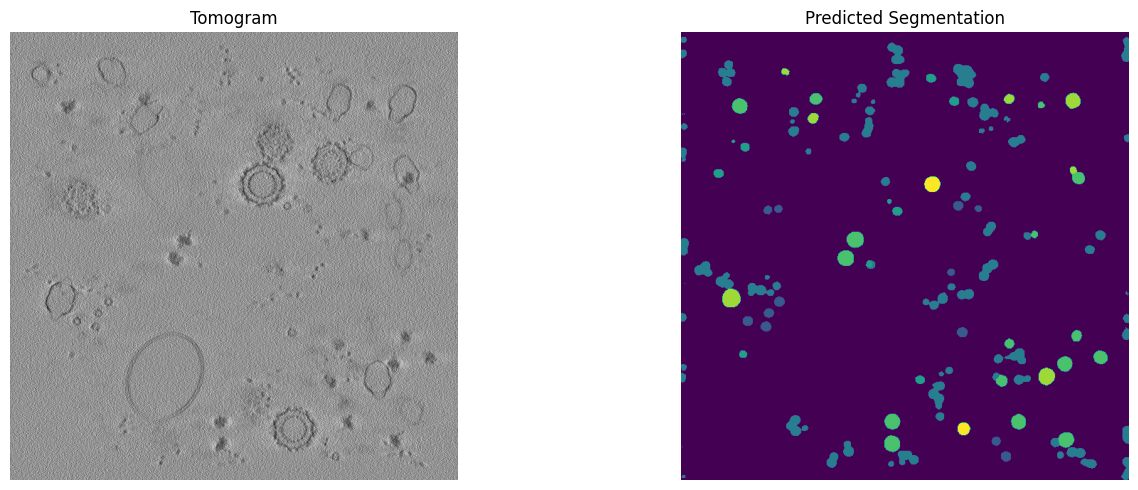

In [8]:
# Plot the images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(train_tomogram[90,],cmap='gray')
plt.axis('off')

# Original Image
plt.subplot(1, 2, 2)
plt.title('Predicted Segmentation')
plt.imshow(train_target[90,])
plt.axis('off')

plt.tight_layout()
plt.show()

#### Step 4: Measure Protein Coordinates from Segmentation Maps

With the segmentation masks, we can filter potential 

In [9]:
from deepfindET.entry_points import step4

# Session ID for the Output Picks
picks_session_id = '0'

segmentation_session_id = '0'

segmentation_name = 'predict' 

min_protein_size = 0.4  

path_output = f"{copick_root.root_overlay}/ExperimentRuns"

In [10]:
# Derived from https://github.com/copick/DeepFindET/blob/main/deepfindET/entry_points/step4.py

import deepfindET.utils.copick_tools as tools
import deepfindET.utils.evaluate as evaluate
import scipy.ndimage as ndimage
from tqdm import tqdm

# Currently Filtering Process always finds coordinate at (cx,cy,cz) - center coordinate
# This seems to always be at the first row, so we can remove it 
remove_index = 0

# Extract Protein Coordinates from the Segmentation Masks
def extract_coords(pickable_object, copick_run):
    labelmap = tools.get_copick_segmentation(copick_run, segmentation_name, user_id, segmentation_session_id)[:]
    label = pickable_object.label
    protein_name = pickable_object.name
    label_objs, _ = ndimage.label(labelmap == label)

    # Filter Candidates based on Object Size
    # Get the sizes of all objects
    object_sizes = np.bincount(label_objs.flat)

    # Filter the objects based on size
    min_object_size = 4/3 * np.pi * ((pickable_object.radius/voxel_size)**2) * min_protein_size
    valid_objects = np.where(object_sizes > min_object_size)[0]                          

    # Estimate Coordiantes from CoM for LabelMaps
    deepFinderCoords = []
    for object_num in tqdm(valid_objects):
        com = ndimage.center_of_mass(label_objs == object_num)
        swapped_com = (com[2], com[1], com[0])
        deepFinderCoords.append(swapped_com)
    deepFinderCoords = np.array(deepFinderCoords)   

    # For some reason, consistently extracting center coordinate
    # Remove the row with the closest index
    deepFinderCoords = np.delete(deepFinderCoords, remove_index, axis=0)                    

    # Estimate Distance Threshold Based on 1/2 of Particle Diameter
    threshold = np.ceil(  pickable_object.radius / (voxel_size * 3) )

    try: 
        # Remove Double Counted Coordinates
        deepFinderCoords = evaluate.remove_repeated_picks(deepFinderCoords, threshold)

        # Append Euler Angles to Coordinates [ Expand Dimensions from Nx3 -> Nx6 ]
        deepFinderCoords = np.concatenate((deepFinderCoords, np.zeros(deepFinderCoords.shape)),axis=1)

        # Convert from Voxel to Physical Units
        deepFinderCoords *= voxel_size

    except Exception as e:
        print(f"Error processing label {label} in tomo {copick_run}: {e}")
        deepFinderCoords = np.array([]).reshape(0,6)

    # Save Picks in Copick Format / Directory 
    tools.write_copick_output(protein_name, copick_run.meta.name, deepFinderCoords, path_output, pickMethod=user_id, sessionID = picks_session_id)
    
    
for run in copick_root.runs:
    print(f"Run {run}")
    for pickable_object in copick_root.pickable_objects:
        print(pickable_object.name)
        if pickable_object.is_particle:
            extract_coords(pickable_object, run)


Localization Parameters:  {
    "input": {
        "predict_config": "config_10439.json",
        "voxel_size": 10,
        "user_id": "deepfindET",
        "segmentation_name": "predict",
        "segmentation_session_id": "1"
    },
    "output": {
        "user_id": "deepfindET",
        "picks_session_id": "1",
        "min_protein_size": 0.4,
        "path_output": "overlay_10439",
        "starfile_write_path": null,
        "tomo_ids": null
    }
} 

Processing Run: 16172 (0)/27


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]


Error processing label 6 in tomo 16172: The number of observations cannot be determined on an empty distance matrix.


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.38it/s]


Processing Run: 16173 (1)/27


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Error processing label 6 in tomo 16173: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by check_pairwise_arrays.


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.38it/s]


Processing Run: 16174 (2)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


Processing Run: 16175 (3)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.36it/s]


Processing Run: 16176 (4)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


Processing Run: 16177 (5)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.40it/s]


Processing Run: 16178 (6)/27


100%|███████████████████████████████████████████| 11/11 [00:07<00:00,  1.40it/s]


Processing Run: 16179 (7)/27


100%|███████████████████████████████████████████| 11/11 [00:08<00:00,  1.37it/s]


Processing Run: 16180 (8)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


Processing Run: 16181 (9)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.39it/s]


Processing Run: 16182 (10)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.38it/s]


Processing Run: 16183 (11)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


Processing Run: 16184 (12)/27


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Error processing label 6 in tomo 16184: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by check_pairwise_arrays.


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.40it/s]


Processing Run: 16185 (13)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.37it/s]


Processing Run: 16186 (14)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.37it/s]


Processing Run: 16187 (15)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


Processing Run: 16188 (16)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.36it/s]


Processing Run: 16189 (17)/27


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Processing Run: 16190 (18)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.37it/s]


Processing Run: 16191 (19)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.40it/s]


Processing Run: 16192 (20)/27


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.40it/s]


Processing Run: 16193 (21)/27


100%|███████████████████████████████████████████| 11/11 [00:07<00:00,  1.41it/s]


Processing Run: 16194 (22)/27


100%|█████████████████████████████████████████████| 8/8 [00:05<00:00,  1.41it/s]


Processing Run: 16195 (23)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


Processing Run: 16196 (24)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


Processing Run: 16197 (25)/27


100%|███████████████████████████████████████████| 11/11 [00:07<00:00,  1.38it/s]


Processing Run: 16198 (26)/27


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]

Extraction of Particle Coordinates Complete!


#### Step 5: Generate a Kaggle submission file

Now we need to generate a submission.csv for Kaggle

In [30]:
import csv
import os

os.listdir("/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns")

results = []
pick_id = 0

# id,experiment,particle_type,x,y,z
for run in copick_root.runs:
    run_id = run.meta.name
    for particle_type in copick_root.pickable_objects:
        picks = run.get_picks(particle_type.name, user_id="deepfindET")
        if picks:
            picks = picks[0]
            points = picks.points
            for point in points:                
                row = [pick_id, run_id, particle_type.name, point.location.x, point.location.y, point.location.z]
                results.append(row)
                pick_id += 1

print(f"Found {len(results)} picks")

# Define CSV output file path
output_csv_path = "/kaggle/working/submission.csv"

# Write results to CSV
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write header
    writer.writerow(["id", "experiment", "particle_type", "x", "y", "z"])
    # Write data rows
    writer.writerows(results)
    



Evaluation for adp-mitochondrial: 
{'precision': 0.8564102564102564, 'recall': 0.7076271186440678, 'f1_score': 0.7749419953596287, 'accuracy': 0.6325757575757576, 'true_positives': 167, 'false_positives': 28, 'false_negatives': 69}

Evaluation for alkaline-phosphate: 
{'precision': 0.1611842105263158, 'recall': 0.0394842868654311, 'f1_score': 0.06343042071197412, 'accuracy': 0.032754010695187165, 'true_positives': 49, 'false_positives': 255, 'false_negatives': 1192}

Evaluation for nucleosome: 
{'precision': 0.8036529680365296, 'recall': 0.8543689320388349, 'f1_score': 0.828235294117647, 'accuracy': 0.7068273092369478, 'true_positives': 176, 'false_positives': 43, 'false_negatives': 30}

Evaluation for ribosome: 
{'precision': 0.9259259259259259, 'recall': 0.8522727272727273, 'f1_score': 0.8875739644970415, 'accuracy': 0.7978723404255319, 'true_positives': 75, 'false_positives': 6, 'false_negatives': 13}

Evaluation for vault: 
{'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'accura